## Introduction to Machine Learning with Python - part5
#### Scikit-learn을 중심으로 ML 관련 내용을 정리하였습니다. 파이썬 라이브러리를 활용한 머신러닝(번역개정2판, 안드레아스 뮐러, 세라 가이도 지음)을 참고하였습니다.

## 6. 알고리즘 체인과 파이프라인

In [1]:
import mglearn
import matplotlib.pyplot as plt
from matplotlib import rc
#### matplotlib 한글 세팅
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import sklearn

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print("테스트 점수 : {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수 : 0.97


###  6.1 데이터 전처리와 매개변수 선택

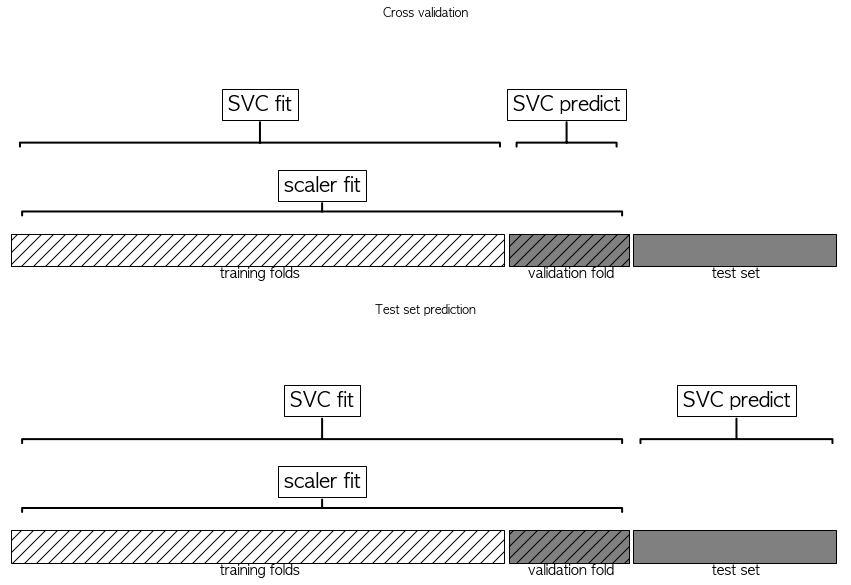

In [4]:
mglearn.plots.plot_improper_processing()

### 6.2 파이프라인 구축하기

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC())])
pipe.fit(X_train, y_train)
print('테스트 점수 : {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수 : 0.97


### 6.3 그리드 서치에 파이프라인 적용하기

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svm__C' : [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 교차 검증 정확도 : {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test, y_test)))
print('최적의 매개 변수', grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 세트 점수 : 0.97
최적의 매개 변수 {'svm__C': 1, 'svm__gamma': 1}


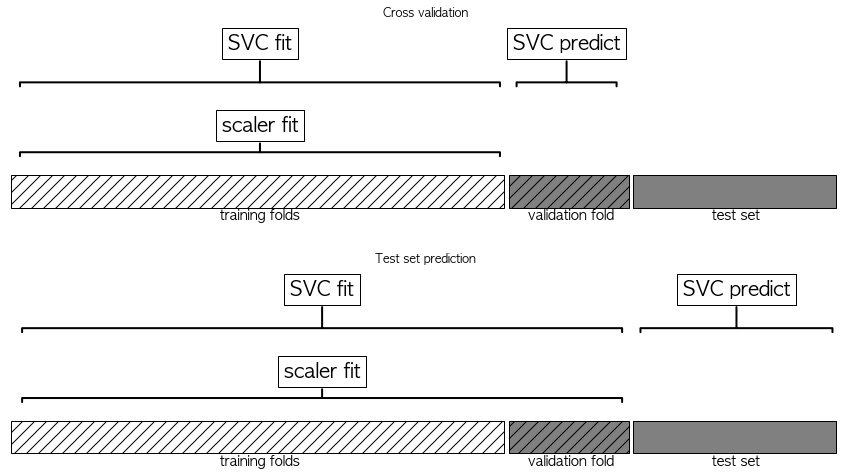

In [7]:
mglearn.plots.plot_proper_processing()

### 6.4 파이프라인 인터페이스
#### 파이프라인에 들어갈 추정기는 마지막 단계를 제외하고는 모두 transform 메서드를 가지고 있어야 합니다.

#### 6.4.1 make_pipeline을 사용한 파이프라인 생성

In [9]:
from sklearn.pipeline import make_pipeline
pipe_long = Pipeline([('scaler', MinMaxScaler()), ('svm', SVC(C=100))])
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

print('파이프라인 단계 : \n', pipe_short.steps)

파이프라인 단계 : 
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인의 단계 : \n', pipe)

파이프라인의 단계 : 
 Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('standardscaler-2', StandardScaler())])


#### 6.4.2 단계 속성에 접근하기

In [12]:
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print('components.shape : ', components.shape)

components.shape :  (2, 30)


#### 6.4.3 그리드 서치 안의 파이프라인 속성에 접근하기

In [16]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
param_grid = {
    'logisticregression__C' : [0.01, 0.1, 1, 10, 100]
}
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('최상의 모델 : \n', grid.best_estimator_)
print('로지스틱 회귀 단계 : \n', grid.best_estimator_.named_steps['logisticregression'])
print('로지스틱 회귀 계수 : \n', grid.best_estimator_.named_steps['logisticregression'].coef_)

최상의 모델 : 
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])
로지스틱 회귀 단계 : 
 LogisticRegression(C=1, max_iter=1000)
로지스틱 회귀 계수 : 
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

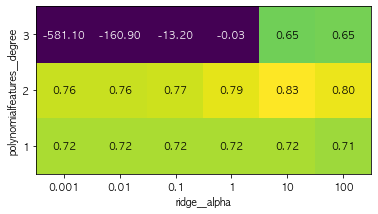

In [18]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),
                    PolynomialFeatures(),
                    Ridge())
param_grid = {
    'polynomialfeatures__degree' : [1,2,3],
    'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1),
                     xlabel='ridge__alpha', ylabel='polynomialfeatures__degree',
                     xticklabels=param_grid['ridge__alpha'],
                     yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [21]:
print('최적의 매개변수 : ', grid.best_params_)
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test, y_test)))

최적의 매개변수 :  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
테스트 세트 점수 : 0.77


In [22]:
param_grid = {'ridge__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print('다항 특성이 없을 때 점수 : {:.2f}'.format(grid.score(X_test, y_test)))

다항 특성이 없을 때 점수 : 0.63


### 6.6 모델 선택을 위한 그리드 서치

In [25]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {'classifier' : [SVC()], 'preprocessing' : [StandardScaler()],
    'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier' : [RandomForestClassifier(n_estimators=100)],
    'preprocessing' : [None],
    'classifier__max_features' : [1,2,3]}
]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print('최적의 매개변수 : \n{}\n'.format(grid.best_params_))
print('최상의 교차 검즘 정수 : {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수 : {:.2f}'.format(grid.score(X_test, y_test)))

최적의 매개변수 : 
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검즘 정수 : 0.99
테스트 세트 점수 : 0.98
